# Parcial 2


## Previo

Se importan los paquetes y se aplica el formato general


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as wid
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
import colorcet as cc
import os
import copy
from matplotlib.patches import FancyBboxPatch
import uncertainties as un
from uncertainties.umath import *


Se configuran las gráficas, tengase en cuenta que algunos pueden no cargar por dependencias a instalar pendientes.


In [2]:
# Configuración general de las gráficas
%matplotlib inline
mpl.rcParams.update(
    {
        "legend.fontsize": 20,
        "axes.labelsize": 24,  # Updated from 20 to 24
        "axes.titlesize": 24,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "figure.titlesize": 24,
        "axes.titlepad": 10,
        "text.usetex": True,
        "font.family": "Times New Roman",
        "mathtext.fontset": "dejavusans",
        "font.size": 20,
        "axes.labelweight": "bold",
        "axes.grid.which": "both",
        "axes.grid": True,
        "grid.alpha": 0.5,
        "axes.formatter.limits": (-3, 3),  # Use scientific notation for values outside the range 10^-3 to 10^3
        'figure.subplot.bottom': 0.2,
    }
)

colors = cc.glasbey_dark
# Configuracion de colores
k = 3

# Rotar la lista: número positivo para rotar a la derecha, negativo para rotar a la izquierda
colors = colors[-k:] + colors[:-k]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)

# Test
if False:
    plt.figure(figsize=(5, 5))
    plt.plot([1, 2, 3, 4], [1, 4, 9, 16], "o")
    plt.plot([4, 3, 2, 1], [1, 2, 3, 4], "o")
    plt.plot([1, 2, 3, 4], [1, 2, 3, 4], "s")
    plt.plot([4, 3, 2, 1], [1, 4, 9, 16], "s")
    plt.title("Test")
    plt.xlabel("X-axis Label", fontweight="bold")
    plt.ylabel("Y-axis Label")
    plt.show()

## Lecturas

In [3]:
# Read the CSV file as df_22Na
df_22Na = pd.read_csv('22Na-previa2.csv')

# Display the first few rows of the dataframe
df_22Na.head()

,canal,cuentas
0,1,0
1,2,769
2,3,2472
3,4,1718
4,5,1787


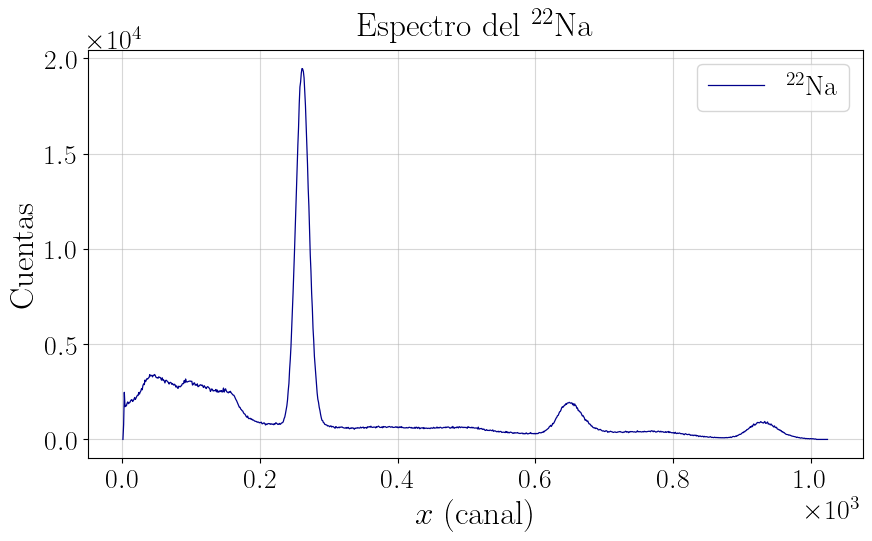

In [4]:
# plotting
fig, ax = plt.subplots(figsize=(10, 6))
df = df_22Na
ax.plot(df["canal"], df["cuentas"], label='$^{22}$Na', color='darkblue', lw=0.9)
ax.set_xlabel("$x$ (canal)")
ax.set_ylabel("Cuentas")

ax.set_title(r"Espectro del $^{22}$Na")
#ax.set_yscale("log")
ax.legend()
fig.savefig("espectro_22na_log.pdf", format='pdf')
plt.show()

In [5]:
# Filtrar los datos entre los canales 227 y 300
min_range=227
max_range = 300
df_filtered = df[(df['canal'] >= min_range) & (df['canal'] <= max_range)]


# Definir la función gaussiana
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Datos para el ajuste
x_data = df_filtered['canal']
y_data = df_filtered['cuentas']

# Ajustar la curva gaussiana
popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[max(y_data), x_data.mean(), 10])

# Parámetros ajustados
a, x0, sigma = popt

# Graficar los datos y el ajuste
ax.plot(x_data, gaussian(x_data, *popt), 'r--', label='Ajuste Gaussiano')


# Imprimir los parámetros ajustados
print(f"Amplitud (a): {a}")
print(f"Media (x0): {x0}")
print(f"Desviación estándar (sigma): {sigma}")

Amplitud (a): 19191.684879709224
Media (x0): 261.58120042532687
Desviación estándar (sigma): 10.15531885394664


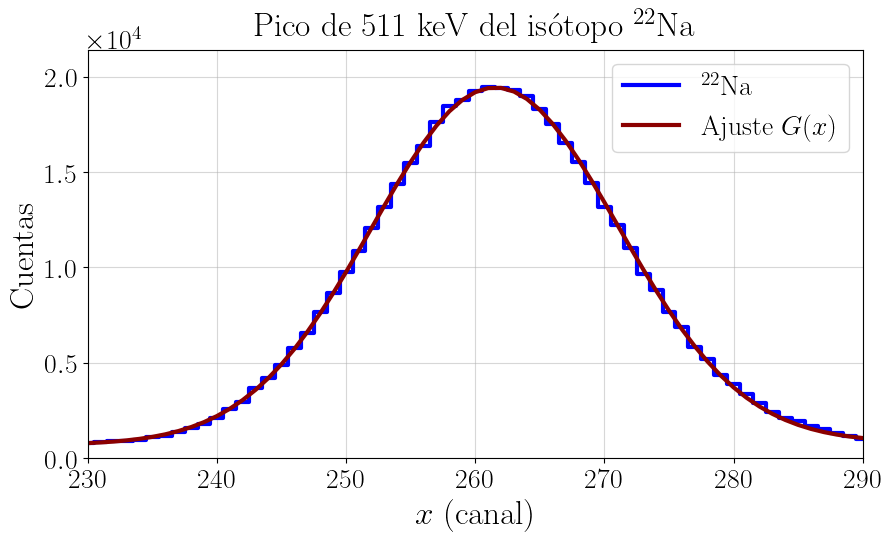

Amplitud (a): 18678.136455000305 ± 37.04048215891185
Media (x0): 261.5440189137512 ± 0.021694076174318667
Desviación estándar (sigma): 9.566285973922046 ± 0.025845505172270727
Pendiente del fondo (m): 2.0634808621200285 ± 0.6771845644431815
Intersección del fondo (b): 223.71085635208536 ± 182.71973948736823
Intensidad: 447885.32969901216 ± 1501.0503505574272


In [6]:
# Filtrar los datos entre los canales 227 y 300
min_range=227
max_range = 300
df_filtered = df[(df['canal'] >= min_range) & (df['canal'] <= max_range)]

# Definir la función gaussiana con fondo lineal
def gaussian_with_background(x, a, x0, sigma, m, b):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + m * x + b

# Ajustar la curva gaussiana con fondo
popt, pcov = curve_fit(gaussian_with_background, x_data, y_data, p0=[max(y_data), x_data.mean(), 10, 0, min(y_data)])

# Parámetros ajustados
a, x0, sigma, m, b = popt

# Graficar los datos y el ajuste
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['canal'], df['cuentas'], label='$^{22}$Na', color='blue', lw=3, ds='steps-mid')
ax.plot(x_data, gaussian_with_background(x_data, *popt), label='Ajuste $G(x)$', color='darkred', lw=3)
ax.set_xlabel("$x$ (canal)")
ax.set_ylabel("Cuentas")
ax.set_title(r"Pico de 511 keV del isótopo $^{22}$Na")
ax.legend()
ax.set_xlim([230, 290])
ax.set_ylim([0, max(y_data) * 1.1])
fig.savefig("pico_22na_511kev.pdf", format='pdf')
plt.show()

# Imprimir los parámetros ajustados con incertidumbre
a_err, x0_err, sigma_err, m_err, b_err = np.sqrt(np.diag(pcov))

print(f"Amplitud (a): {a} ± {a_err}")
print(f"Media (x0): {x0} ± {x0_err}")
print(f"Desviación estándar (sigma): {sigma} ± {sigma_err}")
print(f"Pendiente del fondo (m): {m} ± {m_err}")
print(f"Intersección del fondo (b): {b} ± {b_err}")
# Calcular la intensidad como el área bajo la curva de la gaussiana
intensidad = a * sigma * np.sqrt(2 * np.pi)

# Calcular la incertidumbre de la intensidad
intensidad_err = intensidad * np.sqrt((a_err / a)**2 + (sigma_err / sigma)**2)

# Imprimir la intensidad con incertidumbre
print(f"Intensidad: {intensidad} ± {intensidad_err}")


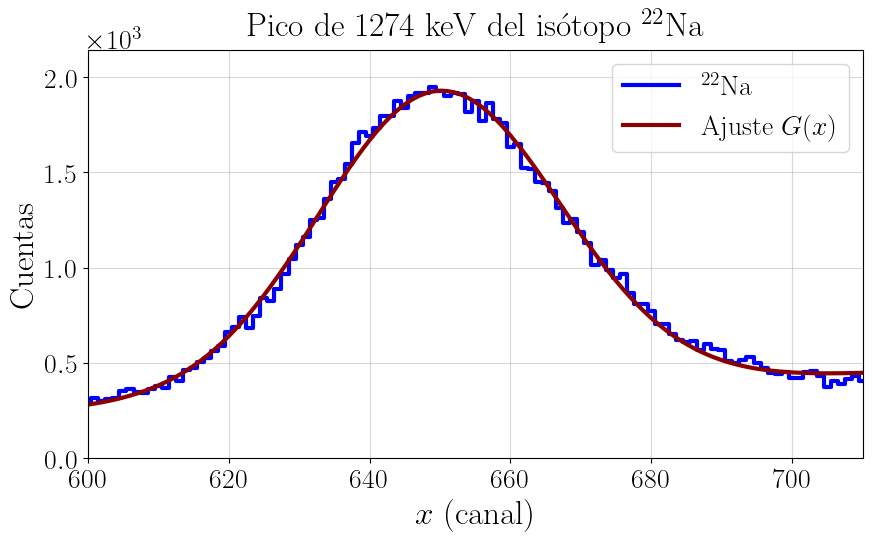

Amplitud (a): 1587.1821204386176 ± 9.915488906481038
Media (x0): 649.8986100632901 ± 0.12003924679808951
Desviación estándar (sigma): 17.172398436339822 ± 0.15477026641138011
Pendiente del fondo (m): 1.7029850174044312 ± 0.1337514712322597
Intersección del fondo (b): -765.1930864287584 ± 90.31839570730304
Intensidad: 68319.96783038582 ± 749.2094950207289


In [7]:
min_range=600
max_range = 710
df_filtered = df[(df['canal'] >= min_range) & (df['canal'] <= max_range)]

# Definir la función gaussiana
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Datos para el ajuste
x_data = df_filtered['canal']
y_data = df_filtered['cuentas']

# Definir la función gaussiana con fondo lineal
def gaussian_with_background(x, a, x0, sigma, m, b):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + m * x + b

# Ajustar la curva gaussiana con fondo
popt, pcov = curve_fit(gaussian_with_background, x_data, y_data, p0=[max(y_data), x_data.mean(), 1, 0, min(y_data)])

# Parámetros ajustados
a, x0, sigma, m, b = popt

# Graficar los datos y el ajuste
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['canal'], df['cuentas'], label='$^{22}$Na', color='blue', lw=3, ds='steps-mid')
ax.plot(x_data, gaussian_with_background(x_data, *popt), label='Ajuste $G(x)$', color='darkred', lw=3)
ax.set_xlabel("$x$ (canal)")
ax.set_ylabel("Cuentas")
ax.set_title(r"Pico de 1274 keV del isótopo $^{22}$Na")
ax.legend()
ax.set_xlim([min_range, max_range])
ax.set_ylim([0, max(y_data) * 1.1])
fig.savefig("pico_22na_1274kev.pdf", format='pdf')
plt.show()

# Imprimir los parámetros ajustados con incertidumbre
a_err, x0_err, sigma_err, m_err, b_err = np.sqrt(np.diag(pcov))

print(f"Amplitud (a): {a} ± {a_err}")
print(f"Media (x0): {x0} ± {x0_err}")
print(f"Desviación estándar (sigma): {sigma} ± {sigma_err}")
print(f"Pendiente del fondo (m): {m} ± {m_err}")
print(f"Intersección del fondo (b): {b} ± {b_err}")
# Calcular la intensidad como el área bajo la curva de la gaussiana
intensidad = a * sigma * np.sqrt(2 * np.pi)

# Calcular la incertidumbre de la intensidad
intensidad_err = intensidad * np.sqrt((a_err / a)**2 + (sigma_err / sigma)**2)

# Imprimir la intensidad con incertidumbre
print(f"Intensidad: {intensidad} ± {intensidad_err}")

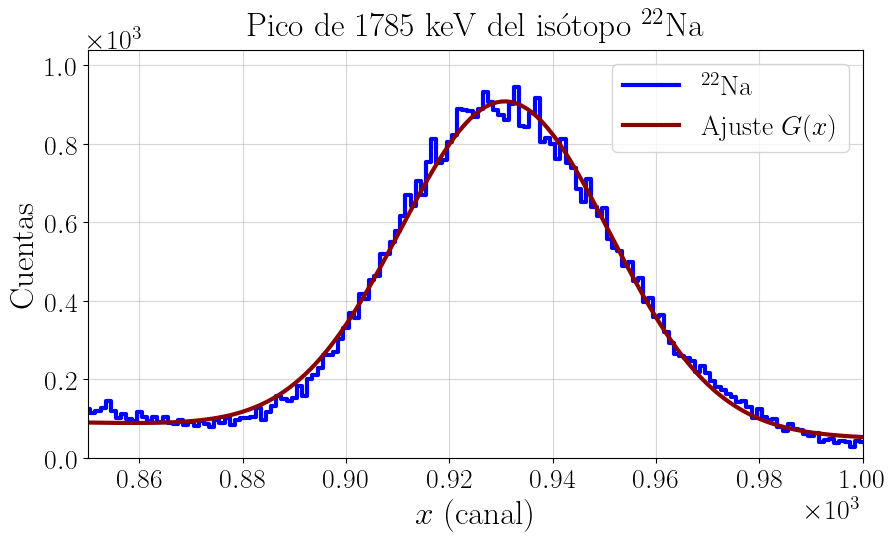

Amplitud (a): 839.6693246260311 ± 5.707693182999929
Media (x0): 930.8319216722562 ± 0.1569293538158256
Desviación estándar (sigma): 20.229248194828997 ± 0.19002775066807998
Pendiente del fondo (m): -0.26118830574374 ± 0.052575907265242874
Intersección del fondo (b): 312.0106972805884 ± 48.05626518450215
Intensidad: 42577.28499559512 ± 493.69185799369455


In [8]:
min_range=850
max_range = 1000
df_filtered = df[(df['canal'] >= min_range) & (df['canal'] <= max_range)]

# Definir la función gaussiana
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Datos para el ajuste
x_data = df_filtered['canal']
y_data = df_filtered['cuentas']

# Definir la función gaussiana con fondo lineal
def gaussian_with_background(x, a, x0, sigma, m, b):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + m * x + b

# Ajustar la curva gaussiana con fondo
popt, pcov = curve_fit(gaussian_with_background, x_data, y_data, p0=[max(y_data), x_data.mean(), 1, 0, min(y_data)])

# Parámetros ajustados
a, x0, sigma, m, b = popt

# Graficar los datos y el ajuste
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['canal'], df['cuentas'], label='$^{22}$Na', color='blue', lw=3, ds='steps-mid')
ax.plot(x_data, gaussian_with_background(x_data, *popt), label='Ajuste $G(x)$', color='darkred', lw=3)
ax.set_xlabel("$x$ (canal)")
ax.set_ylabel("Cuentas")
ax.set_title(r"Pico de 1785 keV del isótopo $^{22}$Na")
ax.legend()
ax.set_xlim([min_range, max_range])
ax.set_ylim([0, max(y_data) * 1.1])
fig.savefig("pico_22na_1785kev.pdf", format='pdf')
plt.show()

# Imprimir los parámetros ajustados con incertidumbre
a_err, x0_err, sigma_err, m_err, b_err = np.sqrt(np.diag(pcov))

print(f"Amplitud (a): {a} ± {a_err}")
print(f"Media (x0): {x0} ± {x0_err}")
print(f"Desviación estándar (sigma): {sigma} ± {sigma_err}")
print(f"Pendiente del fondo (m): {m} ± {m_err}")
print(f"Intersección del fondo (b): {b} ± {b_err}")

# Calcular la intensidad como el área bajo la curva de la gaussiana
intensidad = a * sigma * np.sqrt(2 * np.pi)

# Calcular la incertidumbre de la intensidad
intensidad_err = intensidad * np.sqrt((a_err / a)**2 + (sigma_err / sigma)**2)

# Imprimir la intensidad con incertidumbre
print(f"Intensidad: {intensidad} ± {intensidad_err}")


## Ajuste calibracion

In [9]:
import scipy.stats

# Datos experimentales
mu = np.array([261.54, 649.90, 930.83])  # Valores de canal
E_gamma = np.array([511, 1274, 1785])  # Energía en keV
sigma_mu = np.array([0.022, 0.12, 0.16])  # Incertidumbres en mu

# Ajuste lineal ponderado (considerando incertidumbre en mu)
popt, pcov = np.polyfit(mu, E_gamma, 1, cov=True, w=1/sigma_mu)
a1, a0 = popt  # Coeficientes
err_a1, err_a0 = np.sqrt(np.diag(pcov))  # Incertidumbres

a0, err_a0, a1, err_a1


(7.47892985586038, 9.278530280972527, 1.9260148572212654, 0.03025648927227489)

In [10]:
def canal_a_energia(canal, a0, a1):
    """
    Convierte el valor de canal a energía utilizando la ecuación lineal E = a1 * canal + a0.

    Parámetros:
    canal (float o numpy.ndarray): El valor del canal o una serie de valores de canal.
    a0 (float): El término independiente de la ecuación lineal.
    a1 (float): El coeficiente de la variable independiente en la ecuación lineal.

    Retorna:
    float o numpy.ndarray: El valor de la energía correspondiente al canal.
    """
    return a1 * canal + a0

# Ejemplo de uso
canales = np.array([261.54, 649.90, 930.83])
energias = canal_a_energia(canales, a0, a1)
print(energias)

[ 511.20885561 1259.19598556 1800.2713394 ]


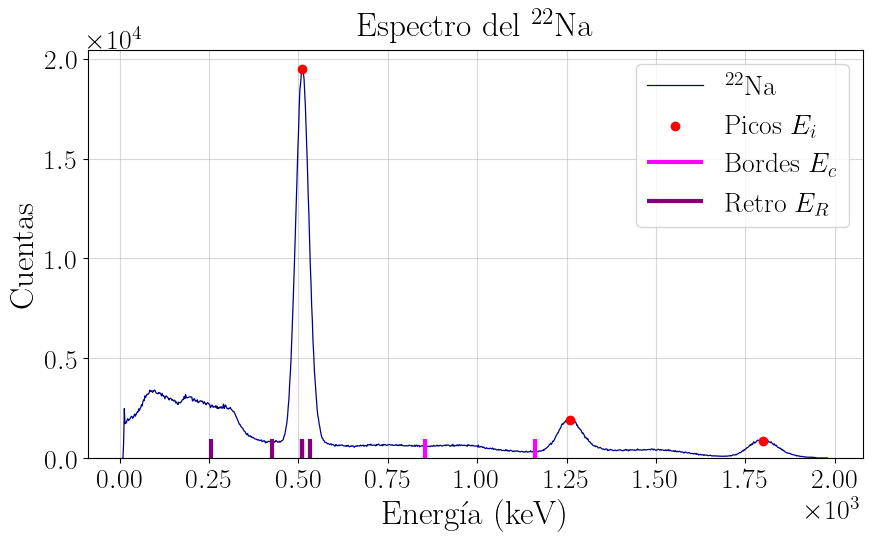

In [11]:
E_picos = [511, 1259, 1800]
Ec = [511, 853, 1162]
ER = [255.5, 426.8, 531.5]

df_22Na['energia'] = canal_a_energia(df_22Na['canal'], a0, a1)
# Graficar energía vs cuentas
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_22Na['energia'], df_22Na['cuentas'], label='$^{22}$Na', color='darkblue', lw=0.9)
# Encontrar los valores de cuentas correspondientes a las energías cercanas en Ec
puntos_compton = [df_22Na.iloc[(df_22Na['energia'] - e).abs().argmin()]['cuentas'] for e in E_picos]
ax.scatter(E_picos, puntos_compton, color='red', zorder=5, label='Picos $E_i$')
for e in Ec:
    ax.vlines(e, -100, 9.4e2, color='#FF00FF', linestyle='-', lw=3)
ax.vlines(Ec[0], -100, 9.4e2, color='#FF00FF', linestyle='-', label='Bordes $E_c$', lw=3)
for i in ER:
    ax.vlines(i, -100, 9.4e2, color='purple', linestyle='-', lw=3)
ax.vlines(Ec[0], -100, 9.4e2, color='purple', linestyle='-', label='Retro $E_R$', lw=3)
ax.set_xlabel("Energía (keV)")
ax.set_ylabel("Cuentas")
ax.set_title(r"Espectro del $^{22}$Na")
ax.set_ylim([0, None])
ax.legend()
fig.savefig("espectro_22na_energia.pdf", format='pdf')
plt.show()

In [12]:
# Read the .dat files as dataframes
df_137Cs = pd.read_csv('137Cs-previa2.dat', delim_whitespace=True, header=None, names=['canal', 'cuentas'], skiprows=1)
df_fondo = pd.read_csv('fondo-previa2.dat', delim_whitespace=True, header=None, names=['canal', 'cuentas'], skiprows=1)

# # Restar las columnas 'cuentas' del df_137Cs con el df_fondo
df_137Cs['cuentas'] = df_137Cs['cuentas']- df_fondo['cuentas']


C:\Users\pinzo\AppData\Local\Temp\ipykernel_14876\1880269027.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_137Cs = pd.read_csv('137Cs-previa2.dat', delim_whitespace=True, header=None, names=['canal', 'cuentas'], skiprows=1)
C:\Users\pinzo\AppData\Local\Temp\ipykernel_14876\1880269027.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_fondo = pd.read_csv('fondo-previa2.dat', delim_whitespace=True, header=None, names=['canal', 'cuentas'], skiprows=1)


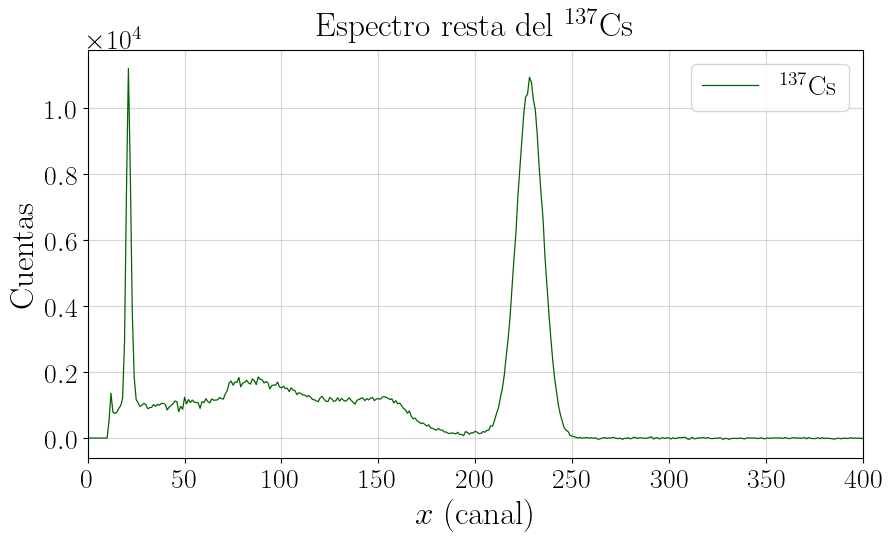

In [13]:
# Plotting df_137Cs and df_fondo
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_137Cs["canal"], df_137Cs["cuentas"], label='$^{137}$Cs', color='darkgreen', lw=0.9)
#ax.plot(df_fondo["canal"], df_fondo["cuentas"], label='Fondo', color='darkred', lw=0.9)
ax.set_xlabel("$x$ (canal)")
ax.set_ylabel("Cuentas")
ax.set_title(r"Espectro resta del $^{137}$Cs")
ax.legend()
ax.set_xlim([0, 0.4e3])
fig.savefig("espectro_137cs_fondo.pdf", format='pdf')
plt.show()

In [14]:
# Nuevos valores de energía para los picos
E_nuevos = np.array([33, 611])

# Valores de canal correspondientes a los picos
canales_picos = np.array([20.7, 227])

# Ajuste lineal para obtener los nuevos coeficientes a0 y a1
popt_nuevos = np.polyfit(canales_picos, E_nuevos, 1)
a1_nuevo, a0_nuevo = popt_nuevos  # Nuevos coeficientes

a0_nuevo, a1_nuevo

(-24.996122152205558, 2.801745031507514)

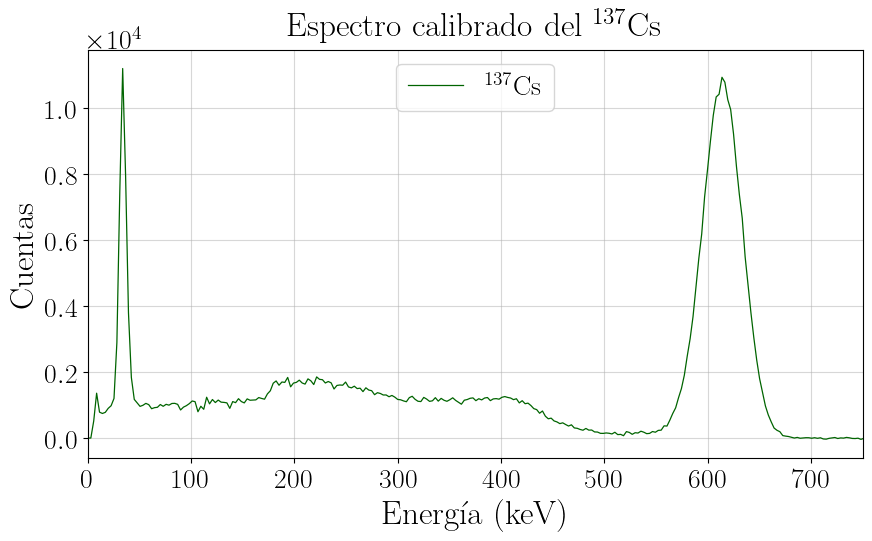

In [15]:
# Aplicar la calibración a los datos de df_137Cs
df_137Cs['energia'] = canal_a_energia(df_137Cs['canal'], a0_nuevo, a1_nuevo)

# Graficar energía vs cuentas para el nuevo conjunto de datos
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_137Cs['energia'], df_137Cs['cuentas'], label='$^{137}$Cs', color='darkgreen', lw=0.9)
ax.set_xlabel("Energía (keV)")
ax.set_ylabel("Cuentas")
ax.set_title(r"Espectro calibrado del $^{137}$Cs")
ax.legend()
ax.set_xlim([0, 0.75e3])
fig.savefig("espectro_137cs_energia.pdf", format='pdf')
plt.show()

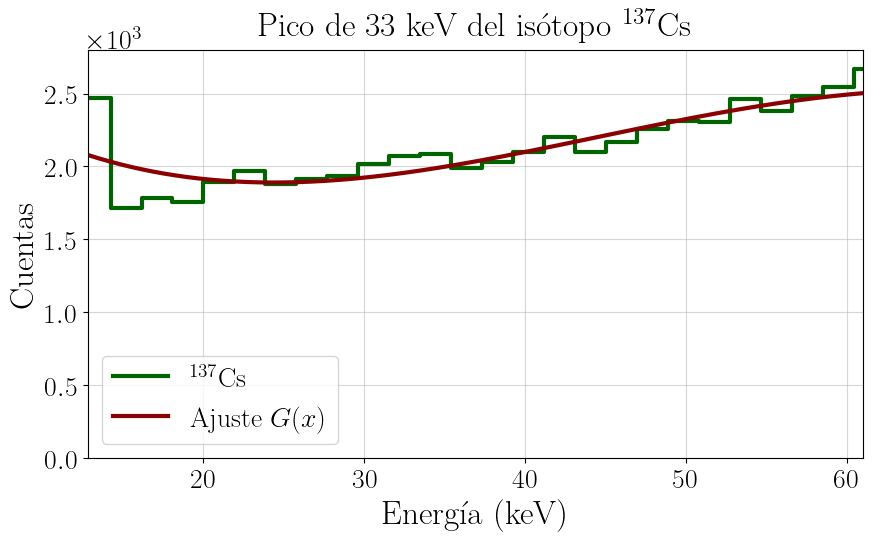

Amplitud (a): -55104.89726307722 ± 10256552.392267074
Media (x0): -40.78603876995298 ± 5221.80730948578
Desviación estándar (sigma): 85.16129593238715 ± 5233.989334351039
Pendiente del fondo (m): -369.45689251963023 ± 48894.97396005666
Intersección del fondo (b): 52016.3319524916 ± 8395385.315488169
Intensidad: -11763116.35463308 ± -2305716306.6440177


In [19]:
# Filtrar los datos entre los canales 540 y 700
min_range = 12.8
max_range = 61
df_filtered = df[(df['energia'] >= min_range) & (df['energia'] <= max_range)]

# Definir la función gaussiana con fondo lineal
def gaussian_with_background(x, a, x0, sigma, m, b):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + m * x + b

# Datos para el ajuste
x_data = df_filtered['energia']
y_data = df_filtered['cuentas']

# Ajustar la curva gaussiana con fondo
popt, pcov = curve_fit(gaussian_with_background, x_data, y_data, p0=[max(y_data), x_data.mean(), 10, 0, min(y_data)])

# Parámetros ajustados
a, x0, sigma, m, b = popt

# Graficar los datos y el ajuste
fig, ax = plt.subplots(figsize=(10, 6))
x_fit = np.linspace(min_range, max_range, 1000)
ax.plot(df['energia'], df['cuentas'], label='$^{137}$Cs', color='darkgreen', lw=3, ds='steps-mid')
ax.plot(x_fit, gaussian_with_background(x_fit, *popt), label='Ajuste $G(x)$', color='darkred', lw=3)
ax.set_xlabel("Energía (keV)")
ax.set_ylabel("Cuentas")
ax.set_title(r"Pico de 33 keV del isótopo $^{137}$Cs")
ax.legend()
ax.set_xlim([min_range, max_range])
ax.set_ylim([0, max(y_data) * 1.1])
fig.savefig("pico_137cs_33kev.pdf", format='pdf')
plt.show()

# Imprimir los parámetros ajustados con incertidumbre
a_err, x0_err, sigma_err, m_err, b_err = np.sqrt(np.diag(pcov))

print(f"Amplitud (a): {a} ± {a_err}")
print(f"Media (x0): {x0} ± {x0_err}")
print(f"Desviación estándar (sigma): {sigma} ± {sigma_err}")
print(f"Pendiente del fondo (m): {m} ± {m_err}")
print(f"Intersección del fondo (b): {b} ± {b_err}")

# Calcular la intensidad como el área bajo la curva de la gaussiana
intensidad = a * sigma * np.sqrt(2 * np.pi)

# Calcular la incertidumbre de la intensidad
intensidad_err = intensidad * np.sqrt((a_err / a)**2 + (sigma_err / sigma)**2)

# Imprimir la intensidad con incertidumbre
print(f"Intensidad: {intensidad} ± {intensidad_err}")

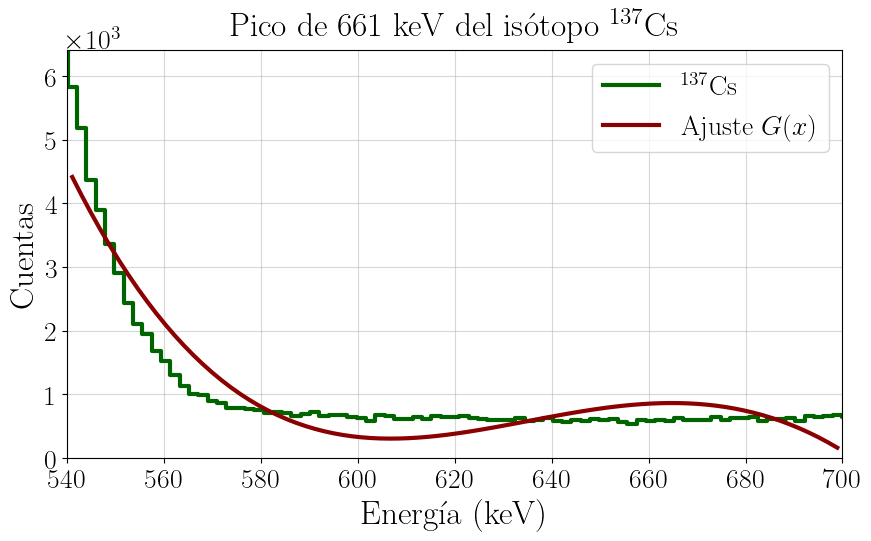

Amplitud (a): -122645.2815769191 ± 1189513.9006945973
Media (x0): 472.50593788413767 ± 526.3509029341151
Desviación estándar (sigma): 162.37176629183492 ± 532.665562463775
Pendiente del fondo (m): -443.66314627718975 ± 2940.5740398210514
Intersección del fondo (b): 356637.2076453626 ± 2591213.911774296
Intensidad: -49917323.82179534 ± -511083425.6116054


In [17]:
# Filtrar los datos entre los canales 540 y 700
min_range = 540
max_range = 700
df_filtered = df[(df['energia'] >= min_range) & (df['energia'] <= max_range)]

# Definir la función gaussiana con fondo lineal
def gaussian_with_background(x, a, x0, sigma, m, b):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + m * x + b

# Datos para el ajuste
x_data = df_filtered['energia']
y_data = df_filtered['cuentas']

# Ajustar la curva gaussiana con fondo
popt, pcov = curve_fit(gaussian_with_background, x_data, y_data, p0=[max(y_data), x_data.mean(), 10, 0, min(y_data)])

# Parámetros ajustados
a, x0, sigma, m, b = popt

# Graficar los datos y el ajuste
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['energia'], df['cuentas'], label='$^{137}$Cs', color='darkgreen', lw=3, ds='steps-mid')
ax.plot(x_data, gaussian_with_background(x_data, *popt), label='Ajuste $G(x)$', color='darkred', lw=3)
ax.set_xlabel("Energía (keV)")
ax.set_ylabel("Cuentas")
ax.set_title(r"Pico de 661 keV del isótopo $^{137}$Cs")
ax.legend()
ax.set_xlim([min_range, max_range])
ax.set_ylim([0, max(y_data) * 1.1])
fig.savefig("pico_137cs_661kev.pdf", format='pdf')
plt.show()

# Imprimir los parámetros ajustados con incertidumbre
a_err, x0_err, sigma_err, m_err, b_err = np.sqrt(np.diag(pcov))

print(f"Amplitud (a): {a} ± {a_err}")
print(f"Media (x0): {x0} ± {x0_err}")
print(f"Desviación estándar (sigma): {sigma} ± {sigma_err}")
print(f"Pendiente del fondo (m): {m} ± {m_err}")
print(f"Intersección del fondo (b): {b} ± {b_err}")

# Calcular la intensidad como el área bajo la curva de la gaussiana
intensidad = a * sigma * np.sqrt(2 * np.pi)

# Calcular la incertidumbre de la intensidad
intensidad_err = intensidad * np.sqrt((a_err / a)**2 + (sigma_err / sigma)**2)

# Imprimir la intensidad con incertidumbre
print(f"Intensidad: {intensidad} ± {intensidad_err}")

In [18]:
# Datos de la tabla
# Incertidumbres dadas
delta_I = np.array([220, 2300])  # Incertidumbre en I (cuentas)
delta_b_gamma = np.array([0.5, 0.5]) / 100  # Incertidumbre en b_gamma (% convertido a fracción)

# Cálculo de la incertidumbre en f
f_uncertainty = f_values * np.sqrt((delta_I / I_values) ** 2 + (delta_b_gamma / b_gamma) ** 2)
f_values, f_uncertainty



NameError: name 'f_values' is not defined

In [ ]:
# Dividir los valores de f_values
f_division = f_values[0] / f_values[1]

# Propagar la incertidumbre
f_division_uncertainty = f_division * np.sqrt((f_uncertainty[0] / f_values[0])**2 + (f_uncertainty[1] / f_values[1])**2)

# Imprimir el resultado
print(f"División de f_values: {f_division} ± {f_division_uncertainty}")

División de f_values: 0.16115428472003396 ± 0.001645837162460504
